# Классификация персонажей из Симпсонов

## Установка зависимостей

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

10.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Fri Nov  8 08:18:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              30W /  70W |   4179MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых нам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch, нормализации входа,
        # а также к трейн датасету применяем аугментации
        transform_train = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            x = transform_train(x) if self.mode == 'train' else transform_test(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

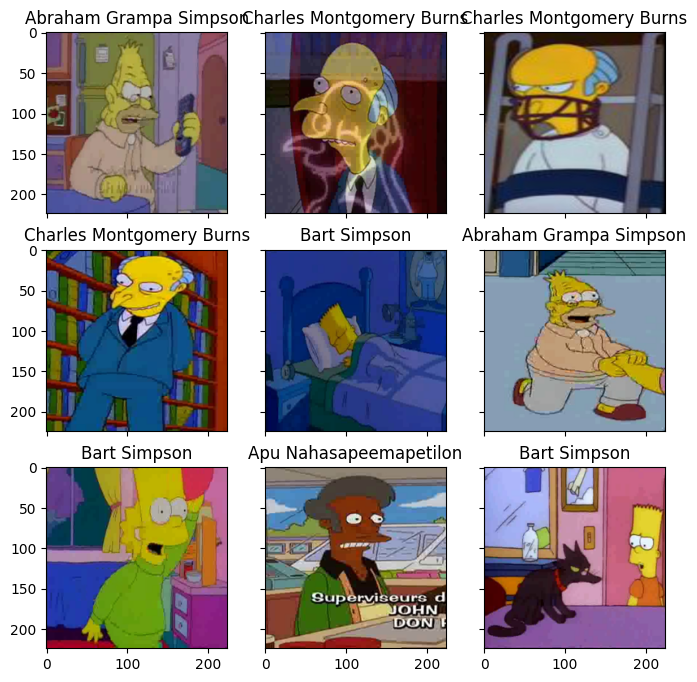

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Построение простенькой нейросетки


### Описание и обучение модели

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, optimizer, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("\nloss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("Мы будем классифицировать : {}".format(n_classes))
print(simple_cnn)

Мы будем классифицировать : 42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=240

Запустим обучение сети.

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')

opt =  torch.optim.Adam(simple_cnn.parameters())

In [ ]:
history_simple_cnn = train(train_dataset, val_dataset, optimizer=opt, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]


loss 2.5939019451293834


epoch:  50%|█████     | 1/2 [02:48<02:48, 168.92s/it]


Epoch 001 train_loss: 2.5939     val_loss 1.9567 train_acc 0.2826 val_acc 0.4545

loss 1.7283480062447685


epoch: 100%|██████████| 2/2 [05:46<00:00, 173.01s/it]


Epoch 002 train_loss: 1.7283     val_loss 1.3576 train_acc 0.5343 val_acc 0.6213


Построим кривые обучения

In [ ]:
def plot_learning_curve(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

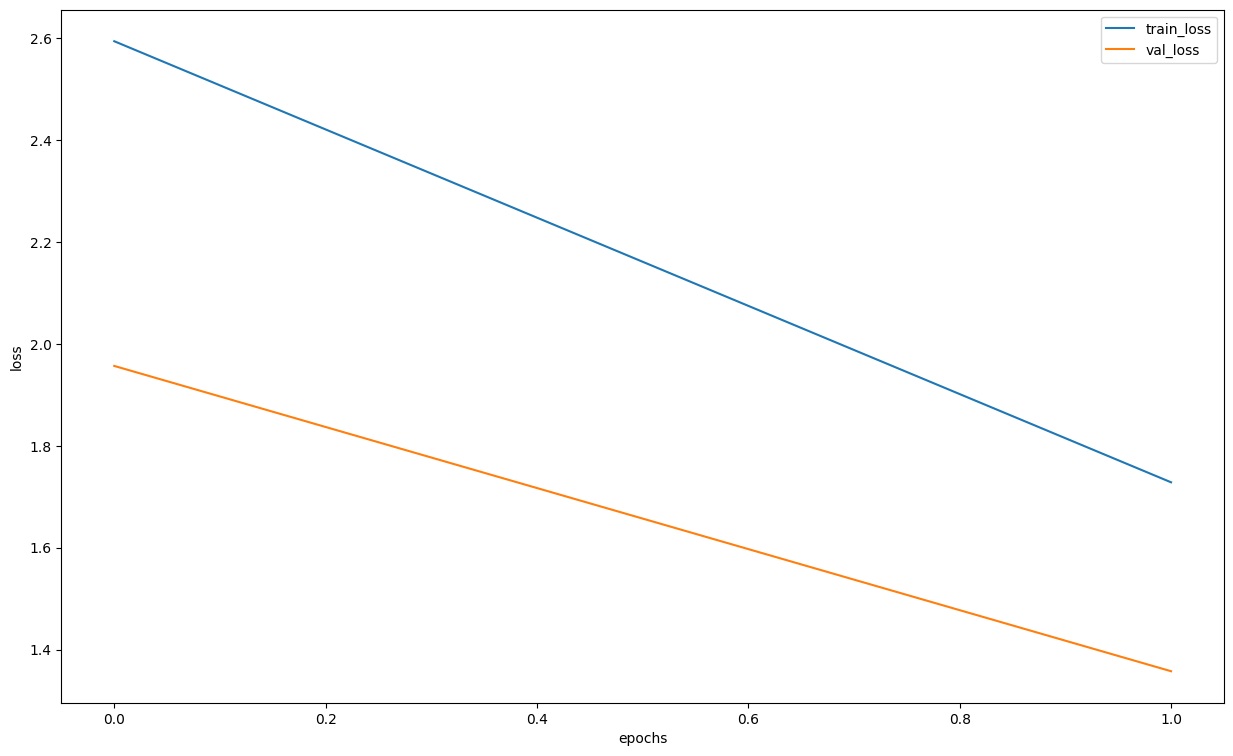

In [ ]:
plot_learning_curve(history_simple_cnn)

### Тестирование модели

Реализуем функции для предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
actual_labels = [val_dataset[id][1] for id in idxs]

In [ ]:
from sklearn.metrics import f1_score

def f1_on_val_dataset(model):
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-оценка:", f1)

In [ ]:
f1_on_val_dataset(simple_cnn)

F1-оценка: 0.55


Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

def confidence_model_in_answers(model):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')

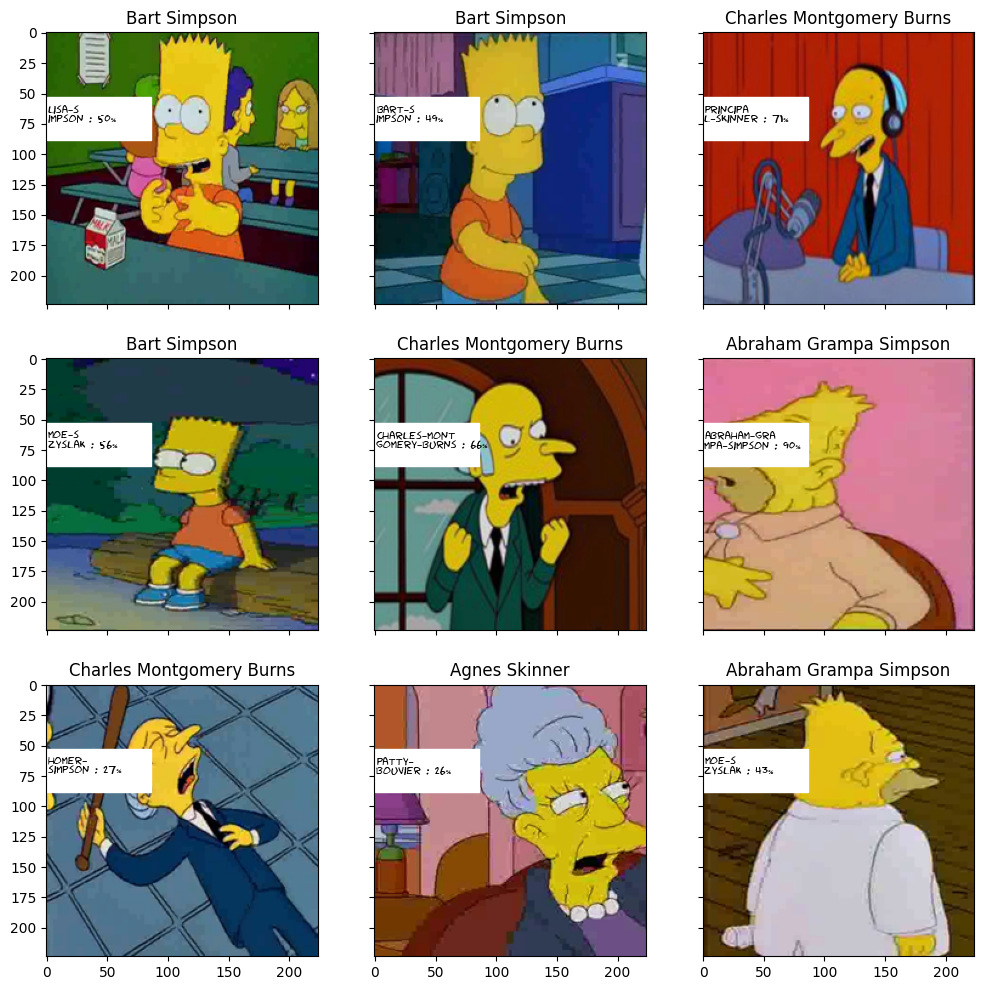

In [ ]:
confidence_model_in_answers(simple_cnn)

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
import pandas as pd

def eval_model_on_test_dataset(model, str):
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    my_submit.to_csv(f'{str}.csv', index=False)

In [ ]:
eval_model_on_test_dataset(simple_cnn, "simple_cnn")

## Апгрейдим первую сетку

Добавим аугментации, батч нормы, попробуем оптимизатор adamW и увеличим количество эпох обучения и размер батчей

In [ ]:
# Простая сеть с добавлением batch norm
class SimpleBatchNormCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
simple_batch_norm_cnn = SimpleBatchNormCnn(n_classes).to(DEVICE)

opt =  torch.optim.AdamW(simple_batch_norm_cnn.parameters())

In [ ]:
history_simple_batch_norm_cnn = train(train_dataset, val_dataset,
                                      model=simple_batch_norm_cnn,
                                      optimizer=opt,
                                      epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 2.1052601922810537


epoch:  10%|█         | 1/10 [02:50<25:34, 170.47s/it]


Epoch 001 train_loss: 2.1053     val_loss 1.5263 train_acc 0.4319 val_acc 0.5755

loss 1.4303529010972322


epoch:  20%|██        | 2/10 [06:06<24:44, 185.59s/it]


Epoch 002 train_loss: 1.4304     val_loss 1.0308 train_acc 0.6035 val_acc 0.7147

loss 1.0577894512563233


epoch:  30%|███       | 3/10 [09:41<23:14, 199.16s/it]


Epoch 003 train_loss: 1.0578     val_loss 0.8788 train_acc 0.7048 val_acc 0.7547

loss 0.8700573462059151


epoch:  40%|████      | 4/10 [13:00<19:52, 198.74s/it]


Epoch 004 train_loss: 0.8701     val_loss 0.7894 train_acc 0.7575 val_acc 0.7883

loss 0.7407874107831632


epoch:  50%|█████     | 5/10 [16:04<16:07, 193.52s/it]


Epoch 005 train_loss: 0.7408     val_loss 0.6937 train_acc 0.7921 val_acc 0.8139

loss 0.6442688395889088


epoch:  60%|██████    | 6/10 [19:10<12:44, 191.03s/it]


Epoch 006 train_loss: 0.6443     val_loss 0.6675 train_acc 0.8175 val_acc 0.8189

loss 0.5599904547292599


epoch:  70%|███████   | 7/10 [22:14<09:26, 188.75s/it]


Epoch 007 train_loss: 0.5600     val_loss 0.6390 train_acc 0.8390 val_acc 0.8359

loss 0.5181405332177466


epoch:  80%|████████  | 8/10 [25:20<06:15, 187.76s/it]


Epoch 008 train_loss: 0.5181     val_loss 0.6254 train_acc 0.8504 val_acc 0.8395

loss 0.4527619402304874


epoch:  90%|█████████ | 9/10 [28:16<03:04, 184.11s/it]


Epoch 009 train_loss: 0.4528     val_loss 0.6181 train_acc 0.8697 val_acc 0.8483

loss 0.41588772935763735


epoch: 100%|██████████| 10/10 [31:42<00:00, 190.25s/it]


Epoch 010 train_loss: 0.4159     val_loss 0.5396 train_acc 0.8788 val_acc 0.8655


Несмотря на то что мы недообучили первую сеть, на первых эпохах видно, что ошибка уменьшилась после апгрейда модели

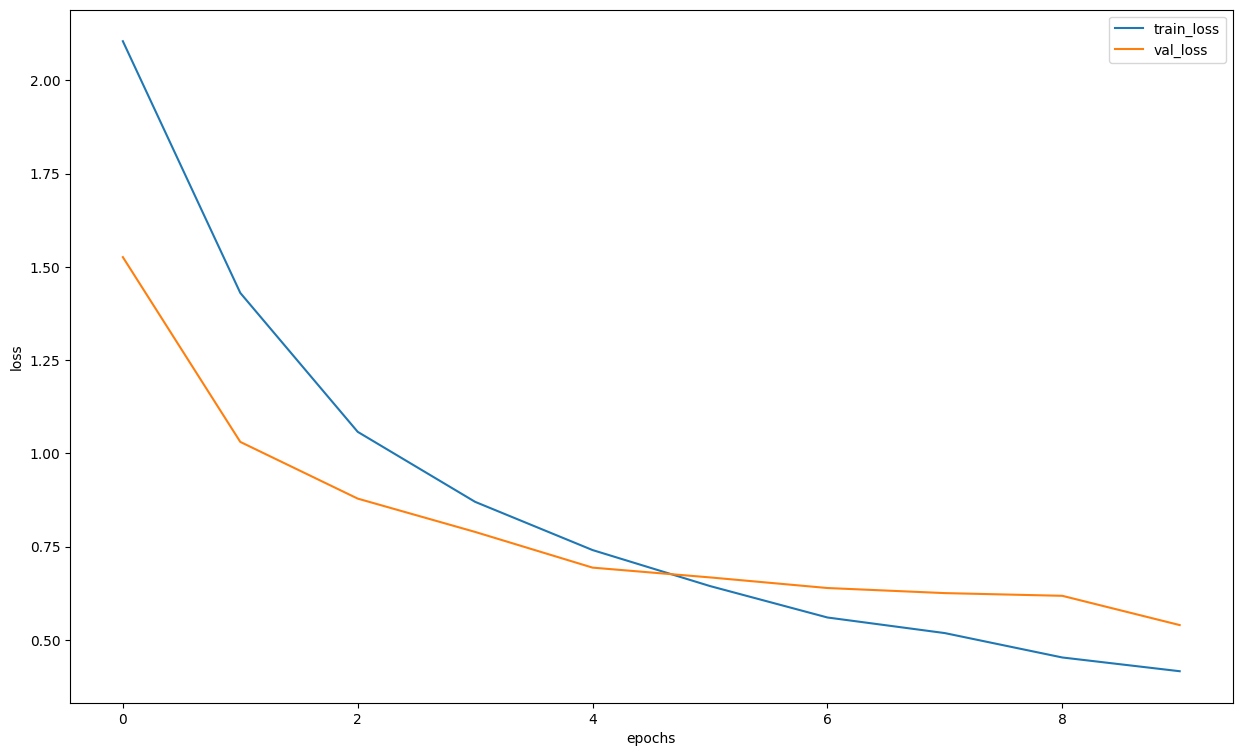

In [ ]:
plot_learning_curve(history_simple_batch_norm_cnn)

Отметим, что в начале обучения ошибка на валидационной выборке была меньше в силу того, что на тренировочной выборке применялись аугментации. После 5-ой эпохи ситуация изменилась

In [ ]:
f1_on_val_dataset(simple_batch_norm_cnn)

F1-оценка: 0.95


In [ ]:
eval_model_on_test_dataset(simple_batch_norm_cnn, "simple_batch_norm_cnn")

## Transfer learning

Теперь попробуем применить transfer learning для достижения лучших результатов на целевой метрике

### ResNet 18

#### Переобучаем последний слой

Сначала попробуем переобучить только последний слой

In [ ]:
from torchvision import models

In [ ]:
models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet_extractor = models.resnet18(pretrained=True)

# замораживаем параметры (веса)
for param in resnet_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
resnet_extractor.fc = nn.Linear(num_features, n_classes)

# Обучаем только классификатор
opt =  torch.optim.AdamW(resnet_extractor.fc.parameters())
resnet_extractor =resnet_extractor.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
history_resnet_extractor = train(train_dataset, val_dataset, model=resnet_extractor, optimizer=opt, epochs=3, batch_size=128)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]


loss 2.5922529474626916


epoch:  33%|███▎      | 1/3 [02:49<05:39, 169.68s/it]


Epoch 001 train_loss: 2.5923     val_loss 2.0875 train_acc 0.3294 val_acc 0.5170

loss 1.8426858898606056


epoch:  67%|██████▋   | 2/3 [05:38<02:49, 169.27s/it]


Epoch 002 train_loss: 1.8427     val_loss 1.6831 train_acc 0.5605 val_acc 0.5908

loss 1.5629343649970322


epoch: 100%|██████████| 3/3 [08:27<00:00, 169.09s/it]


Epoch 003 train_loss: 1.5629     val_loss 1.5140 train_acc 0.6102 val_acc 0.6114


Остановили обучение на трёх эпохах, так как в начале обучения видно, что ошибка достаточно большая по сравнению с нашей предыдущей моделью. Дальше обучать не имеет смысла

#### Смешанный способ

Теперь будем обучать не только последний fully connected слой, но и несколько предпоследних

In [ ]:
resnet_mixed = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet_mixed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from itertools import chain

# Выключаем подсчет градиентов для всех слоев
for param in resnet_mixed.parameters():
    param.requires_grad = False

# Включаем подсчет градиентов для последних слоев, которые будем обучать
for param in resnet_mixed.layer4.parameters():
    param.requires_grad = True
for param in resnet_mixed.avgpool.parameters():
    param.requires_grad = True
for param in resnet_mixed.fc.parameters():
    param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
resnet_mixed.fc = nn.Linear(num_features, n_classes)

# parameters() возвращает просто список тензоров парамтеров, поэтому несколько таких списков можно сложить
opt =  torch.optim.AdamW(
    chain(
        resnet_mixed.layer4.parameters(),
        resnet_mixed.avgpool.parameters(),
        resnet_mixed.fc.parameters()
    ),
    lr=1e-4,
)
resnet_mixed = resnet_mixed.to(DEVICE)

In [ ]:
history_resnet_mixed = train(train_dataset, val_dataset, model=resnet_mixed, optimizer=opt, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 1.5479355810994486


epoch:  10%|█         | 1/10 [02:53<26:03, 173.74s/it]


Epoch 001 train_loss: 1.5479     val_loss 0.7188 train_acc 0.6496 val_acc 0.8424

loss 0.5539932440166921


epoch:  20%|██        | 2/10 [05:44<22:57, 172.25s/it]


Epoch 002 train_loss: 0.5540     val_loss 0.4306 train_acc 0.8590 val_acc 0.8959

loss 0.3633766361988079


epoch:  30%|███       | 3/10 [08:36<20:03, 171.88s/it]


Epoch 003 train_loss: 0.3634     val_loss 0.3528 train_acc 0.9022 val_acc 0.9138

loss 0.2906179858078675


epoch:  40%|████      | 4/10 [11:26<17:08, 171.36s/it]


Epoch 004 train_loss: 0.2906     val_loss 0.2945 train_acc 0.9201 val_acc 0.9228

loss 0.22919679745434726


epoch:  50%|█████     | 5/10 [14:18<14:17, 171.45s/it]


Epoch 005 train_loss: 0.2292     val_loss 0.2478 train_acc 0.9369 val_acc 0.9400

loss 0.19537618188400452


epoch:  60%|██████    | 6/10 [17:08<11:23, 170.96s/it]


Epoch 006 train_loss: 0.1954     val_loss 0.2603 train_acc 0.9463 val_acc 0.9383

loss 0.15227487273535628


epoch:  70%|███████   | 7/10 [19:59<08:32, 170.93s/it]


Epoch 007 train_loss: 0.1523     val_loss 0.3324 train_acc 0.9571 val_acc 0.9148

loss 0.129225647200239


epoch:  80%|████████  | 8/10 [22:50<05:42, 171.05s/it]


Epoch 008 train_loss: 0.1292     val_loss 0.2704 train_acc 0.9628 val_acc 0.9339

loss 0.11797465355388753


epoch:  90%|█████████ | 9/10 [25:40<02:50, 170.75s/it]


Epoch 009 train_loss: 0.1180     val_loss 0.2652 train_acc 0.9660 val_acc 0.9345

loss 0.10224549137188758


epoch: 100%|██████████| 10/10 [28:32<00:00, 171.28s/it]


Epoch 010 train_loss: 0.1022     val_loss 0.2496 train_acc 0.9709 val_acc 0.9429


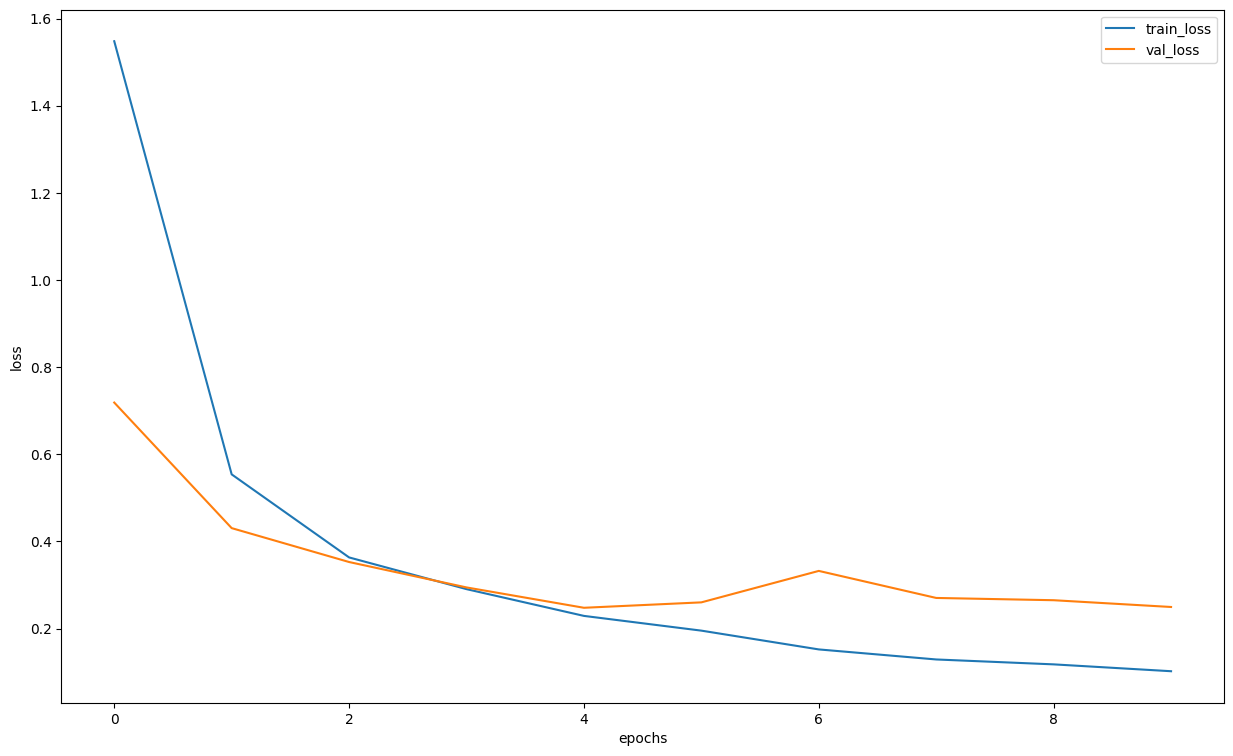

In [ ]:
plot_learning_curve(history_resnet_mixed)

In [ ]:
f1_on_val_dataset(resnet_mixed)

F1-оценка: 0.95


Уже намного лучше

In [ ]:
eval_model_on_test_dataset(resnet_mixed, "resnet_mixed")

### wide_resnet101_2

Попробуем взять архитектуру побольше



Сразу будем переобучать несколько последних слоёв, так как обучение только последнего слоя не дало хороших результатов для ResNet18

In [ ]:
wide_resnet_mixed = models.wide_resnet101_2(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
wide_resnet_mixed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
# Выключаем подсчет градиентов для всех слоев
for param in wide_resnet_mixed.parameters():
    param.requires_grad = False

# Включаем подсчет градиентов для последних слоев, которые будем обучать
for param in wide_resnet_mixed.layer4.parameters():
    param.requires_grad = True
for param in wide_resnet_mixed.avgpool.parameters():
    param.requires_grad = True
for param in wide_resnet_mixed.fc.parameters():
    param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
wide_resnet_mixed.fc = nn.Linear(num_features, n_classes)

# parameters() возвращает просто список тензоров парамтеров, поэтому несколько таких списков можно сложить
opt =  torch.optim.AdamW(
    chain(
        wide_resnet_mixed.layer4.parameters(),
        wide_resnet_mixed.avgpool.parameters(),
        wide_resnet_mixed.fc.parameters()
    ),
    lr=1e-4,
)
wide_resnet_mixed = wide_resnet_mixed.to(DEVICE)

In [ ]:
history_wide_resnet_mixed = train(train_dataset, val_dataset, model=wide_resnet_mixed, optimizer=opt, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 0.5105155624681328


epoch:  10%|█         | 1/10 [06:10<55:37, 370.80s/it]


Epoch 001 train_loss: 0.5105     val_loss 0.2865 train_acc 0.8873 val_acc 0.9391

loss 0.2873944947684113


epoch:  20%|██        | 2/10 [12:13<48:48, 366.04s/it]


Epoch 002 train_loss: 0.2874     val_loss 0.2522 train_acc 0.9280 val_acc 0.9413

loss 0.17826989014039824


epoch:  30%|███       | 3/10 [18:14<42:27, 363.86s/it]


Epoch 003 train_loss: 0.1783     val_loss 0.2291 train_acc 0.9542 val_acc 0.9471

loss 0.12080657006513618


epoch:  40%|████      | 4/10 [24:15<36:16, 362.71s/it]


Epoch 004 train_loss: 0.1208     val_loss 0.1729 train_acc 0.9683 val_acc 0.9627

loss 0.08474004085834363


epoch:  50%|█████     | 5/10 [30:16<30:09, 361.96s/it]


Epoch 005 train_loss: 0.0847     val_loss 0.1627 train_acc 0.9768 val_acc 0.9650

loss 0.06668180808651804


epoch:  60%|██████    | 6/10 [36:18<24:07, 361.86s/it]


Epoch 006 train_loss: 0.0667     val_loss 0.2077 train_acc 0.9821 val_acc 0.9582

loss 0.057257516427673086


epoch:  70%|███████   | 7/10 [42:19<18:05, 361.85s/it]


Epoch 007 train_loss: 0.0573     val_loss 0.2346 train_acc 0.9838 val_acc 0.9570

loss 0.05992064513549654


epoch:  80%|████████  | 8/10 [48:20<12:02, 361.50s/it]


Epoch 008 train_loss: 0.0599     val_loss 0.1849 train_acc 0.9828 val_acc 0.9622

loss 0.051855837596651334


epoch:  90%|█████████ | 9/10 [54:23<06:01, 361.84s/it]


Epoch 009 train_loss: 0.0519     val_loss 0.1883 train_acc 0.9861 val_acc 0.9647

loss 0.044647707986450284


epoch: 100%|██████████| 10/10 [1:00:24<00:00, 362.42s/it]


Epoch 010 train_loss: 0.0446     val_loss 0.1837 train_acc 0.9871 val_acc 0.9658


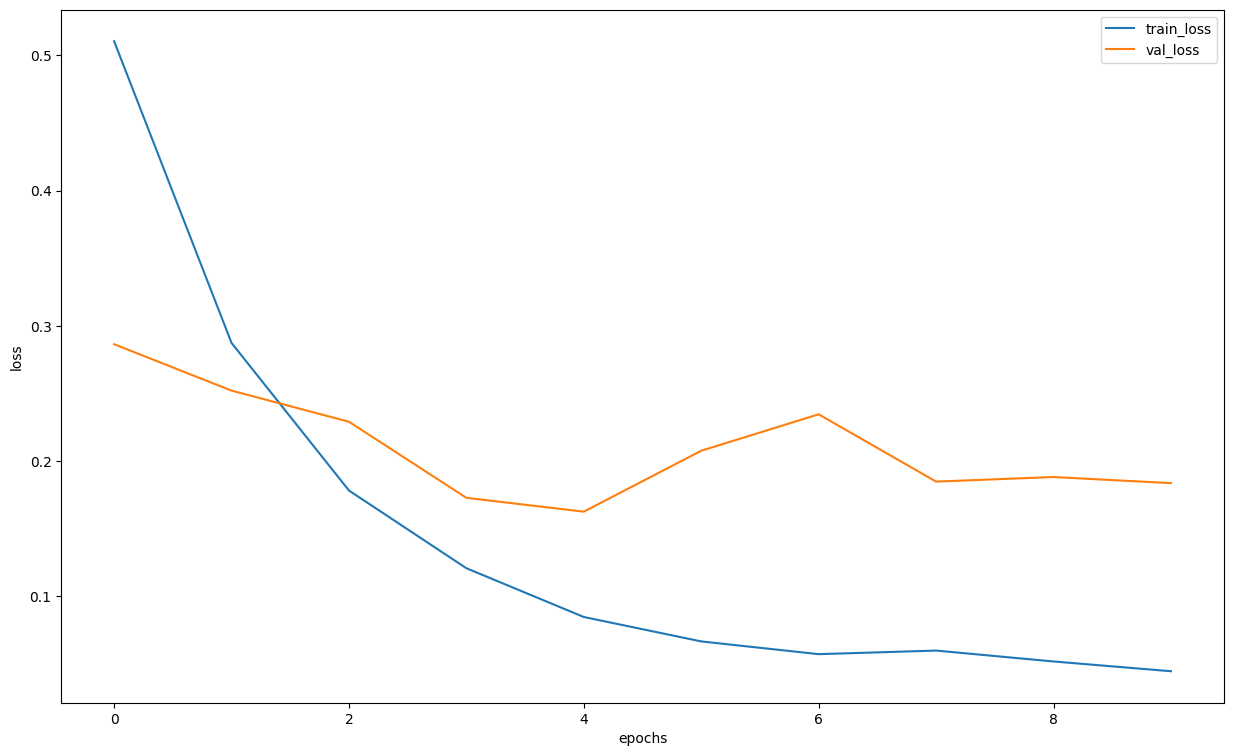

In [ ]:
plot_learning_curve(history_wide_resnet_mixed)

In [ ]:
f1_on_val_dataset(wide_resnet_mixed)

F1-оценка: 1.0


In [ ]:
eval_model_on_test_dataset(wide_resnet_mixed, "wide_resnet_mixed")

Теперь посмторим насколько уверена в своих ответах наша лучшая модель

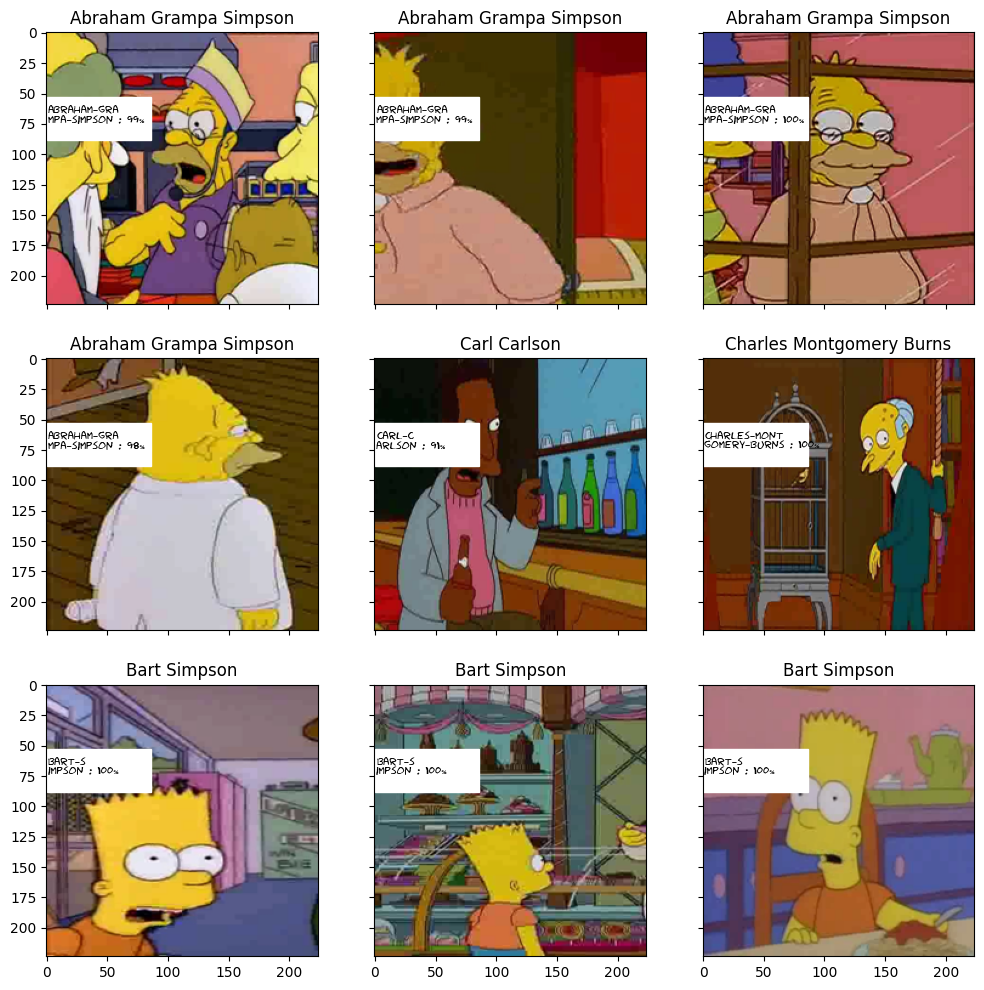

In [ ]:
confidence_model_in_answers(wide_resnet_mixed)

Отличный результат, у модели достаточно высокая степень уверенности в своих ответах

## Сохранение лучшей модели

In [ ]:
model_scripted = torch.jit.script(wide_resnet_mixed) # Export to TorchScript
model_scripted.save('best_model.pt') # Save